In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


/Users/davidstroud/anaconda3/envs/snakes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Read in file
df = pd.read_csv("creditcard.csv")

In [3]:
# View shape of the data
df.shape

(284807, 31)

In [4]:
# Check for missing values
df.isnull().values.any()

False

Text(0,0.5,'Frequency')

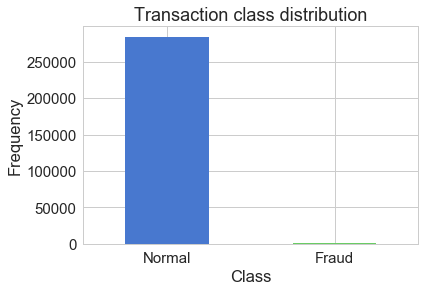

In [6]:
# Plot histogram of Transaction class distribution
count_classes = pd.value_counts(df['Class'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [7]:
# Review of the two normal types of transactions
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [8]:
# View shape of frauds
frauds.shape

(492, 31)

In [9]:
# View shape of normals
normal.shape

(284315, 31)